In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
import os
import pickle
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})

%cd /home/naodell/work/hgcal/ECONAutoencoderStudy

/home/naodell/work/hgcal/ECONAutoencoderStudy


In [6]:
# get the data
input_file = open('data/output_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_z < 0 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut#.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

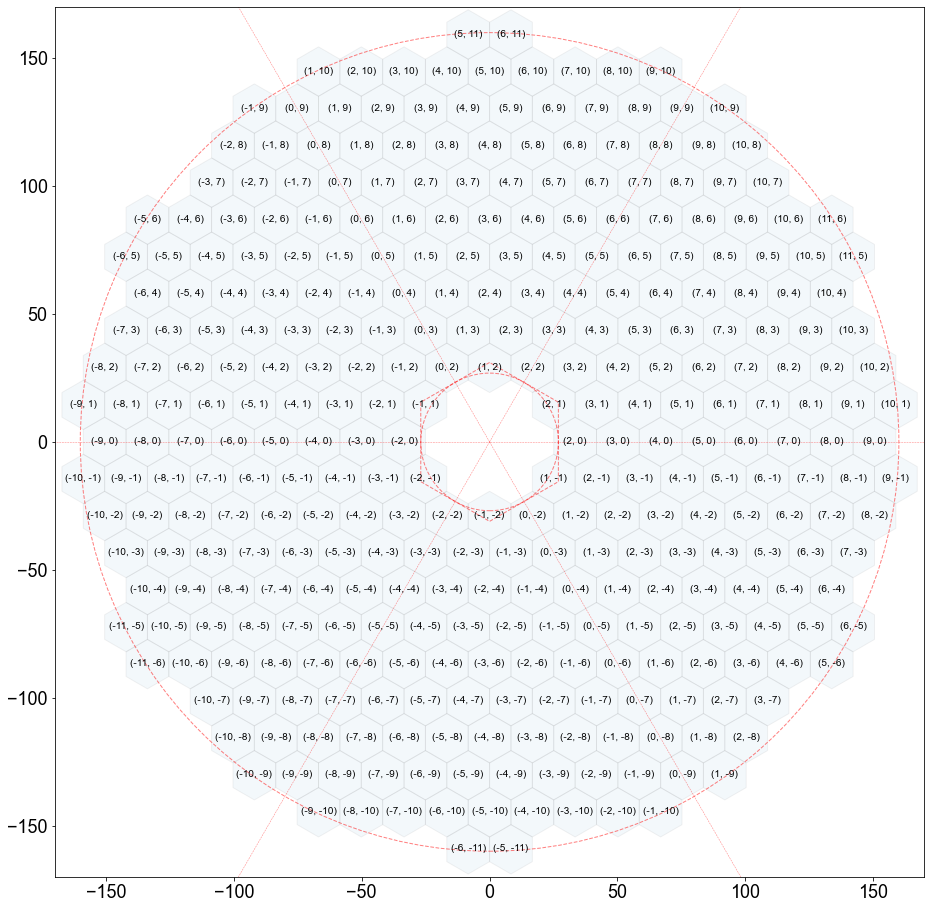

In [7]:
from matplotlib.patches import RegularPolygon, Circle, Polygon
from itertools import product
cmap = matplotlib.cm.get_cmap('Reds')

# draw each module 
u = np.arange(-13, 14)
coord = np.array(list(product(u, u)))

# Horizontal cartesian coords
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
xcoord = [d*(c[0] - c[1]*np.sin(angle)) for c in coord]
ycoord = [d*c[1]*np.sin(np.pi/2 - angle) for c in coord]

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# draw hexegonal grid
inner_radius = 0.82*32.8
outer_radius = 160
for x, y, u, v in zip(xcoord, ycoord, coord.T[0], coord.T[1]):
    
    # filter out wafers
    r = np.sqrt(x**2 + y**2)
    if r < inner_radius or r > outer_radius:
        continue
        
    color = 'C0'
    alpha = 0.05
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=hex_radius, 
                         orientation=np.radians(0), 
                         facecolor=color, 
                         alpha=alpha, 
                         edgecolor='k',
                         zorder=1
                        )
    ax.add_patch(poly)
    
    # Add text labels
    ax.text(x, y+0.2, f'({u}, {v})', ha='center', va='center', size=10)
    
# inner hexagon and circle (just for show)
inner_circle = Circle((0, 0), 
                     radius=inner_radius,
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(inner_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=inner_radius/np.cos(angle), 
                     orientation=np.radians(0), 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                    )
ax.add_patch(poly)

# outer hexagon and circle (just for show)
outer_circle = Circle((0, 0), 
                     radius=160, 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(outer_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=160, 
                     orientation=np.radians(30), 
                     facecolor='none', 
                     alpha=0.5, 
                     edgecolor='r'
                    )

# draw lines every pi/3 radians
for angle in np.arange(0, 360, 60):
    rad = (angle/180)*np.pi
    plt.plot([0., 200*np.cos(rad)], [0., 200*np.sin(rad)], 'r--', linewidth=0.5, alpha=0.5)
    
ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
              
plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive


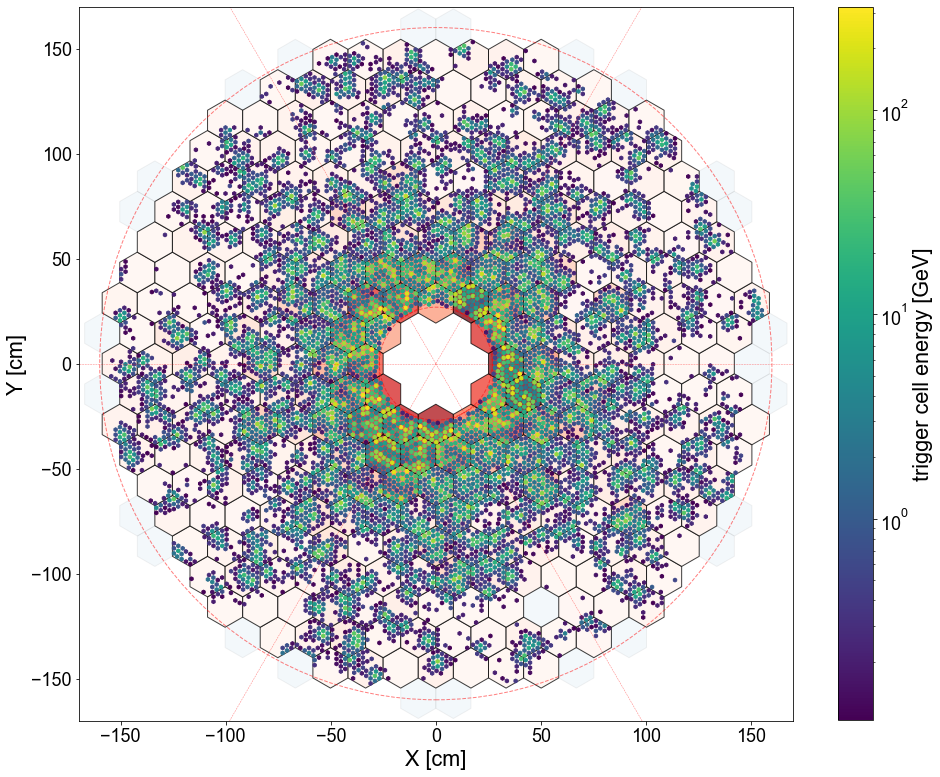

In [8]:
# Draw some events overlaid

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_z < 0 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut#.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

# draw each module 
u = np.arange(-13, 14)
coord = np.array(list(product(u, u)))

# Horizontal cartesian coords
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
#trans_matrix = np.array([[1., np.sin(angle)], [0., np.sin(np.pi/2 - angle)]])
xcoord = [d*(c[0] - c[1]*np.sin(angle)) for c in coord]
ycoord = [d*c[1]*np.sin(np.pi/2 - angle) for c in coord]

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# draw hexegonal grid
inner_radius = 0.82*32.8
outer_radius = 160
energy_max = wafer_sums['tc_energy'].max()
accepted_wafers = []
cmap = matplotlib.cm.get_cmap('Reds')
for x, y, u, v in zip(xcoord, ycoord, coord.T[0], coord.T[1]):
    
    # filter out wafers
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/(x + 0.01)) 
    if (r < inner_radius or r > outer_radius):#  or (phi < -0.05 or phi > 2*angle + 0.05) or (x < 0. or y < 0.):
        continue
        
    accepted_wafers.append((u, v))
    if (u, v) in wafer_sums.index:
        color = cmap(wafer_sums.loc[(u, v), 'tc_energy']/energy_max)
        alpha = 0.75
    else:
        color = 'C0'
        alpha = 0.05
        
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=hex_radius, 
                         orientation=np.radians(0), 
                         facecolor=color, 
                         alpha=alpha, 
                         edgecolor='k',
                         zorder=1
                        )
    ax.add_patch(poly)
    
    # Add text labels
    #if color == 'C0':
    #    ax.text(x, y+0.2, f'({u}, {v})', ha='center', va='center', size=8)
    
# inner hexagon and circle (just for show)
inner_circle = Circle((0, 0), 
                     radius=inner_radius,
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(inner_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=inner_radius/np.cos(angle), 
                     orientation=np.radians(0), 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                    )
ax.add_patch(poly)

# outer hexagon and circle (just for show)
outer_circle = Circle((0, 0), 
                     radius=160, 
                     facecolor='none', 
                     alpha=0.5, 
                     linestyle='--',
                     edgecolor='r'
                     )
ax.add_patch(outer_circle)

poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=160, 
                     orientation=np.radians(30), 
                     facecolor='none', 
                     alpha=0.5, 
                     edgecolor='r'
                    )

# draw lines every pi/3 radians
for angle in np.arange(0, 360, 60):
    rad = (angle/180)*np.pi
    plt.plot([0., 200*np.cos(rad)], [0., 200*np.sin(rad)], 'r--', linewidth=0.5, alpha=0.5)
              
#ax.add_patch(poly)
tc_sums = event_tc.groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 15. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(x, y,
                  marker=(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()

                 )
#ax.set_xlim(-10, 170)
#ax.set_ylim(-20, 160)
ax.set_xlim(-170, 170)
ax.set_ylim(-170, 170)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

plt.show()

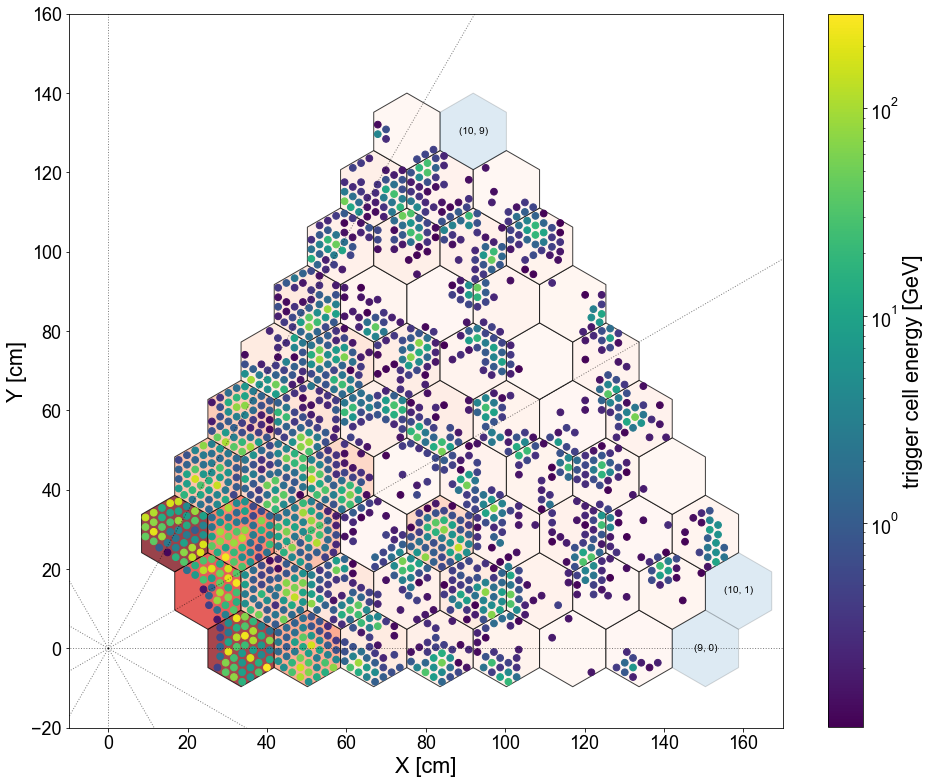

In [19]:
# Draw some events overlaid in the first wedge

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_z < 0 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.1'
df_tc['count'] = 1
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut
#event_tc = df_cut.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

# draw each module 
u = np.arange(-11, 11)
coord = np.array(list(product(u, u)))

# Horizontal cartesian coords
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
#trans_matrix = np.array([[1., np.sin(angle)], [0., np.sin(np.pi/2 - angle)]])
xcoord = [d*(c[0] - c[1]*np.sin(angle)) for c in coord]
ycoord = [d*c[1]*np.sin(np.pi/2 - angle) for c in coord]

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# draw hexegonal grid
inner_radius = 0.82*32.8
outer_radius = 160
energy_max = wafer_sums['tc_energy'].max()
accepted_wafers = []
cmap = matplotlib.cm.get_cmap('Reds')
for x, y, u, v in zip(xcoord, ycoord, coord.T[0], coord.T[1]):
    
    # filter out wafers
    r = np.sqrt(x**2 + y**2)
    phi = np.arctan(y/(x + 0.01)) 
    if (r < inner_radius or r > outer_radius)  or (phi < -0.05 or phi > 2*angle + 0.05) or (x < 0. or y < 0.):
        continue
        
    accepted_wafers.append((u, v))
    if (u, v) in wafer_sums.index:
        color = cmap(wafer_sums.loc[(u, v), 'tc_energy']/energy_max)
        alpha = 0.75
    else:
        color = 'C0'
        alpha = 0.15
        
    poly = RegularPolygon((x, y), 
                         numVertices=6, 
                         radius=hex_radius, 
                         orientation=np.radians(0), 
                         facecolor=color, 
                         alpha=alpha, 
                         edgecolor='k',
                         zorder=1
                        )
    ax.add_patch(poly)
    
    # Add text labels
    if color == 'C0':
        ax.text(x, y+0.2, f'({u}, {v})', ha='center', va='center', size=10)
        
# draw lines every pi/3 radians
for angle in np.arange(0, 360, 30):
    rad = (angle/180)*np.pi
    plt.plot([0., 200*np.cos(rad)], [0., 200*np.sin(rad)], 'k:', linewidth=1, alpha=0.5)
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
wedge_condition = 'tc_waferu >= 2 and tc_waferu >= tc_waferv and tc_waferv >= 0'
tc_sums = event_tc.query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 45. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(x, y,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )
ax.set_xlim(-10, 170)
ax.set_ylim(-20, 160)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

plt.show()

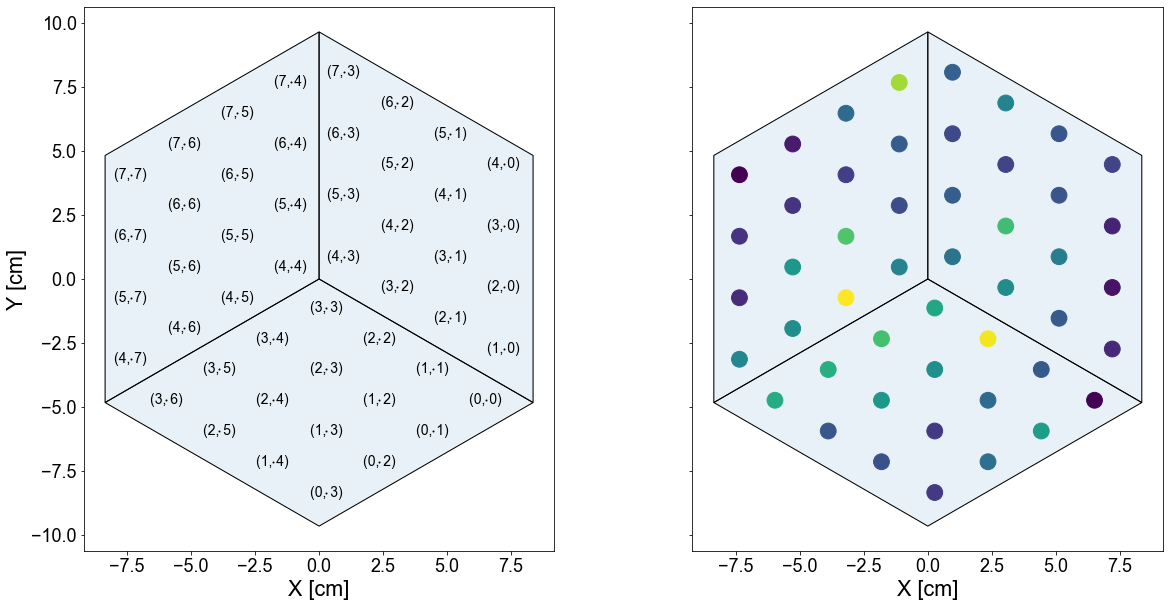

In [46]:
# Draw a single module
fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

ax = axes[0]
ax.set_aspect('equal')

# draw hexegonal grid
angle = np.pi/6
hex_radius = 0.95*8*2.54/2
d = 2*hex_radius*np.cos(angle)
x_offset = d*(3 - 3*np.sin(angle))
y_offset = d*3*np.sin(np.pi/2 - angle)
poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=hex_radius, 
                     orientation=np.radians(0), 
                     facecolor='C0', 
                     alpha=0.1, 
                     edgecolor='k',
                     zorder=1
                        )
ax.add_patch(poly)

# Draw HGROC boundaries
angle = np.pi/6
x1 = np.array([0., 0, hex_radius*np.cos(angle), hex_radius*np.cos(angle)])
y1 = np.array([0., hex_radius, hex_radius*np.sin(angle), -hex_radius*np.sin(angle)])
ax.add_patch(Polygon(xy=list(zip(x1, y1)), fill=False))

x2 = np.array([0., hex_radius*np.cos(angle), 0., -hex_radius*np.cos(angle)])
y2 = np.array([0., -hex_radius*np.sin(angle), -hex_radius, -hex_radius*np.sin(angle)])
ax.add_patch(Polygon(xy=list(zip(x2, y2)), fill=False))

x3 = np.array([0., -hex_radius*np.cos(angle), -hex_radius*np.cos(angle), 0.])
y3 = np.array([0., -hex_radius*np.sin(angle), hex_radius*np.sin(angle), hex_radius])
ax.add_patch(Polygon(xy=list(zip(x3, y3)), fill=False))
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
group_tc = event_tc.query('tc_waferu == 3 and tc_waferv == 3').groupby(['tc_x', 'tc_y']) 
tc_sums = group_tc.sum()
tc_cells = group_tc.apply(lambda x: x.iloc[0])[['tc_cellu', 'tc_cellv']]
scat = ax.scatter(x - x_offset, y - y_offset,
                  marker='o', #(6, 0, 0), 
                  s=1, 
                  c='k',
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )
for (x, y), (u, v) in tc_cells.iterrows():
    u, v = int(u), int(v)
    x, y = x - x_offset, y - y_offset
    ax.text(x, y, f'({u}, {v})', ha='center', va='center', size=14)

#ax.set_xlim(15, 35)
#ax.set_ylim(33, 54)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')

ax = axes[1]
ax.set_aspect('equal')

# draw hexegonal grid
poly = RegularPolygon((0, 0), 
                     numVertices=6, 
                     radius=hex_radius, 
                     orientation=np.radians(0), 
                     facecolor='C0', 
                     alpha=0.1, 
                     edgecolor='k',
                     zorder=1
                        )
ax.add_patch(poly)

# Draw HGROC boundaries
ax.add_patch(Polygon(xy=list(zip(x1, y1)), fill=False))
ax.add_patch(Polygon(xy=list(zip(x2, y2)), fill=False))
ax.add_patch(Polygon(xy=list(zip(x3, y3)), fill=False))
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 250. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(x - x_offset, y - y_offset,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )
#ax.set_xlim(15, 35)
#ax.set_ylim(33, 54)
ax.set_xlabel('X [cm]')
#ax.set_ylabel('Y [cm]')

#cbar = fig.colorbar(scat, ax=ax, shrink=1.82)
#cbar.set_label('trigger cell energy [GeV]')

plt.show()